## Reconhecimento de entidades

In [1]:
import os
import io
import re

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [2]:
import neuralcoref
import spacy 

In [3]:
print('spacy version:', spacy.__version__)
print('neuralcoref version:', neuralcoref.__version__)

spacy version: 2.1.3
neuralcoref version: 4.0.0


In [5]:
def read_file(path):
    try:
        with io.open(path, 'r', encoding='utf-8') as f:
            return f.read()
    except UnicodeDecodeError:
        try:
            with io.open(path, 'r', encoding='latin-1') as f:
                return f.read()
        except UnicodeDecodeError:
            return "Could not decode"
    

In [6]:
folder = "success"

# files sorted by number
files_ordered = sorted(os.listdir(folder), key=lambda name:int(name.split('_')[0]))

# an example file (1)
file = files_ordered[2]
# name file
path = os.path.join(folder, file)

if os.path.isfile(path):
    content = read_file(path)
    print(f"Content of book ... {file}\n")
    # print(content)

Content of book ... 3_TheAdventuresOfCaptainHorn_FrankRichardStockton_cleared.txt



In [7]:
paragraphs = content.split('\n\n')
# print(paragraphs)

In [8]:
paragraphs_new = []
contents = []
chapters = []
old_idx = 0

for paragraph in paragraphs:
    # print("\n Paragraph: ", paragraph)
    
    lines = paragraph.split('\n')
    # print(lines)
    if re.match('[IVXLCDM\d]+[\.]*', lines[0].upper().strip()):
        if len(contents) == 0:
            contents = [" ".join(line.lower().split()) for line in lines]
            # print("contents", contents)
            
            if len(contents) == 0:
                print("Not found content", id_file)
                exit()
        continue
           
    if paragraph.lower().strip() in contents:
        if old_idx == 0:
            old_idx = len(paragraphs_new)
        else:
            current_idx = len(paragraphs_new)
            chapter = "\n\n".join(paragraphs_new[old_idx:current_idx])
            chapters.append(chapter)
            old_idx = current_idx
        continue
    
    if not re.match('.*[\w]+.*', paragraph):
        continue
    
    paragraphs_new.append(paragraph)
 

    if old_idx != 0:
        chapter = "\n\n".join(paragraphs_new[old_idx:len(paragraphs_new)])
        chapters.append(chapter)
        
print(len(paragraphs), len(paragraphs_new),
      #len(chapters)
     )    

1945 1608


In [9]:
nlp = spacy.load('en_core_web_sm')
neuralcoref.add_to_pipe(nlp)

In [30]:
data = []
geral_entities = []

for i, paragraph in enumerate(paragraphs_new[0:15]):
    paragraph = paragraph.replace('\n', ' ')
    paragraph = " ".join(paragraph.split())
    # print('\n', paragraph)****
    
    doc = nlp(paragraph)
    doc_coref = doc._.coref_resolved
    doc_coref = nlp(doc_coref)
    
    entities = []
    for ent in doc_coref.ents:
        if ent.label_ == "PERSON":
            entities.append(ent.text)
    
    if len(entities) > 0:
        len_words = len(paragraph.split())
        geral_entities.extend(entities)
        
        data.append((i, len_words, entities))
        # print('\n', paragraph)
        print(i, len_words, entities)

personagens = list(set(geral_entities) )

print("\nGeral Entities:\n", personagens)
# print("\nData:\n", data)

1 173 ['Philip Horn', 'William Cliff', 'Castor', 'Edna Markham', 'Ralph']
6 67 ['Ralph Markham', 'Ralph Markham', 'Ralph Markham']
7 111 ['Cliff', 'Markham']
9 80 ['Captain Horn', 'Captain Horn']
10 129 ['Horn', 'Captain Horn']
12 42 ['Captain Horn', 'Captain Horn', 'Captain Horn', 'Captain Horn']
13 106 ['Rynders', 'Rynders', 'Captain Horn', 'Ralph', 'Maka']

Geral Entities:
 ['William Cliff', 'Philip Horn', 'Edna Markham', 'Cliff', 'Castor', 'Horn', 'Markham', 'Ralph', 'Captain Horn', 'Maka', 'Rynders', 'Ralph Markham']


In [31]:
geral_entities

['Philip Horn',
 'William Cliff',
 'Castor',
 'Edna Markham',
 'Ralph',
 'Ralph Markham',
 'Ralph Markham',
 'Ralph Markham',
 'Cliff',
 'Markham',
 'Captain Horn',
 'Captain Horn',
 'Horn',
 'Captain Horn',
 'Captain Horn',
 'Captain Horn',
 'Captain Horn',
 'Captain Horn',
 'Rynders',
 'Rynders',
 'Captain Horn',
 'Ralph',
 'Maka']

In [33]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(vocabulary=personagens, stop_words='english')
vect

CountVectorizer(stop_words='english',
                vocabulary=['William Cliff', 'Philip Horn', 'Edna Markham',
                            'Cliff', 'Castor', 'Horn', 'Markham', 'Ralph',
                            'Captain Horn', 'Maka', 'Rynders',
                            'Ralph Markham'])

In [ ]:
name_list = personagens
novel = content



## Criação de rede de coocorrência

In [23]:
import numpy as np

# Inicializa a matriz de coocorrência
cooccurrence_matrix = np.zeros((len(personagens), len(personagens)), dtype=int)

# Preenche a matriz de coocorrência
for _, _, paragraph_entities in data:
    for i in range(len(personagens)):
        if personagens[i] in paragraph_entities:
            for j in range(i, len(personagens)):
                if personagens[j] in paragraph_entities:
                    cooccurrence_matrix[i][j] += 1
                    if i != j:
                        cooccurrence_matrix[j][i] += 1
                               
print("Matriz de Coocorrência:")
print(cooccurrence_matrix)

Matriz de Coocorrência:
[[1 1 1 0 1 0 0 1 0 0 0 0]
 [1 1 1 0 1 0 0 1 0 0 0 0]
 [1 1 1 0 1 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 1 0 0 0 0 0]
 [1 1 1 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 1 0 0 0]
 [0 0 0 1 0 0 1 0 0 0 0 0]
 [1 1 1 0 1 0 0 2 1 1 1 0]
 [0 0 0 0 0 1 0 1 4 1 1 0]
 [0 0 0 0 0 0 0 1 1 1 1 0]
 [0 0 0 0 0 0 0 1 1 1 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 1]]


In [26]:
matrix = cooccurrence_matrix
name_list = personagens

# -------------------------
edge_list = []
shape = matrix.shape[0]
lower_tri_loc = list(zip(*np.where(np.triu(np.ones([shape,shape])) == 0)))
normalized_matrix = matrix / np.max(np.abs(matrix))

weight = np.log(2000 * normalized_matrix + 1) * 0.7
color = np.log(2000 * normalized_matrix + 1)

for i in lower_tri_loc:
    edge_list.append((name_list[i[0]], name_list[i[1]], {'weight': weight[i], 'color': color[i]}))
    
print(edge_list)

[('Philip Horn', 'William Cliff', {'weight': 4.351624270759405, 'color': 6.2166061010848646}), ('Edna Markham', 'William Cliff', {'weight': 4.351624270759405, 'color': 6.2166061010848646}), ('Edna Markham', 'Philip Horn', {'weight': 4.351624270759405, 'color': 6.2166061010848646}), ('Cliff', 'William Cliff', {'weight': 0.0, 'color': 0.0}), ('Cliff', 'Philip Horn', {'weight': 0.0, 'color': 0.0}), ('Cliff', 'Edna Markham', {'weight': 0.0, 'color': 0.0}), ('Castor', 'William Cliff', {'weight': 4.351624270759405, 'color': 6.2166061010848646}), ('Castor', 'Philip Horn', {'weight': 4.351624270759405, 'color': 6.2166061010848646}), ('Castor', 'Edna Markham', {'weight': 4.351624270759405, 'color': 6.2166061010848646}), ('Castor', 'Cliff', {'weight': 0.0, 'color': 0.0}), ('Horn', 'William Cliff', {'weight': 0.0, 'color': 0.0}), ('Horn', 'Philip Horn', {'weight': 0.0, 'color': 0.0}), ('Horn', 'Edna Markham', {'weight': 0.0, 'color': 0.0}), ('Horn', 'Cliff', {'weight': 0.0, 'color': 0.0}), ('Horn

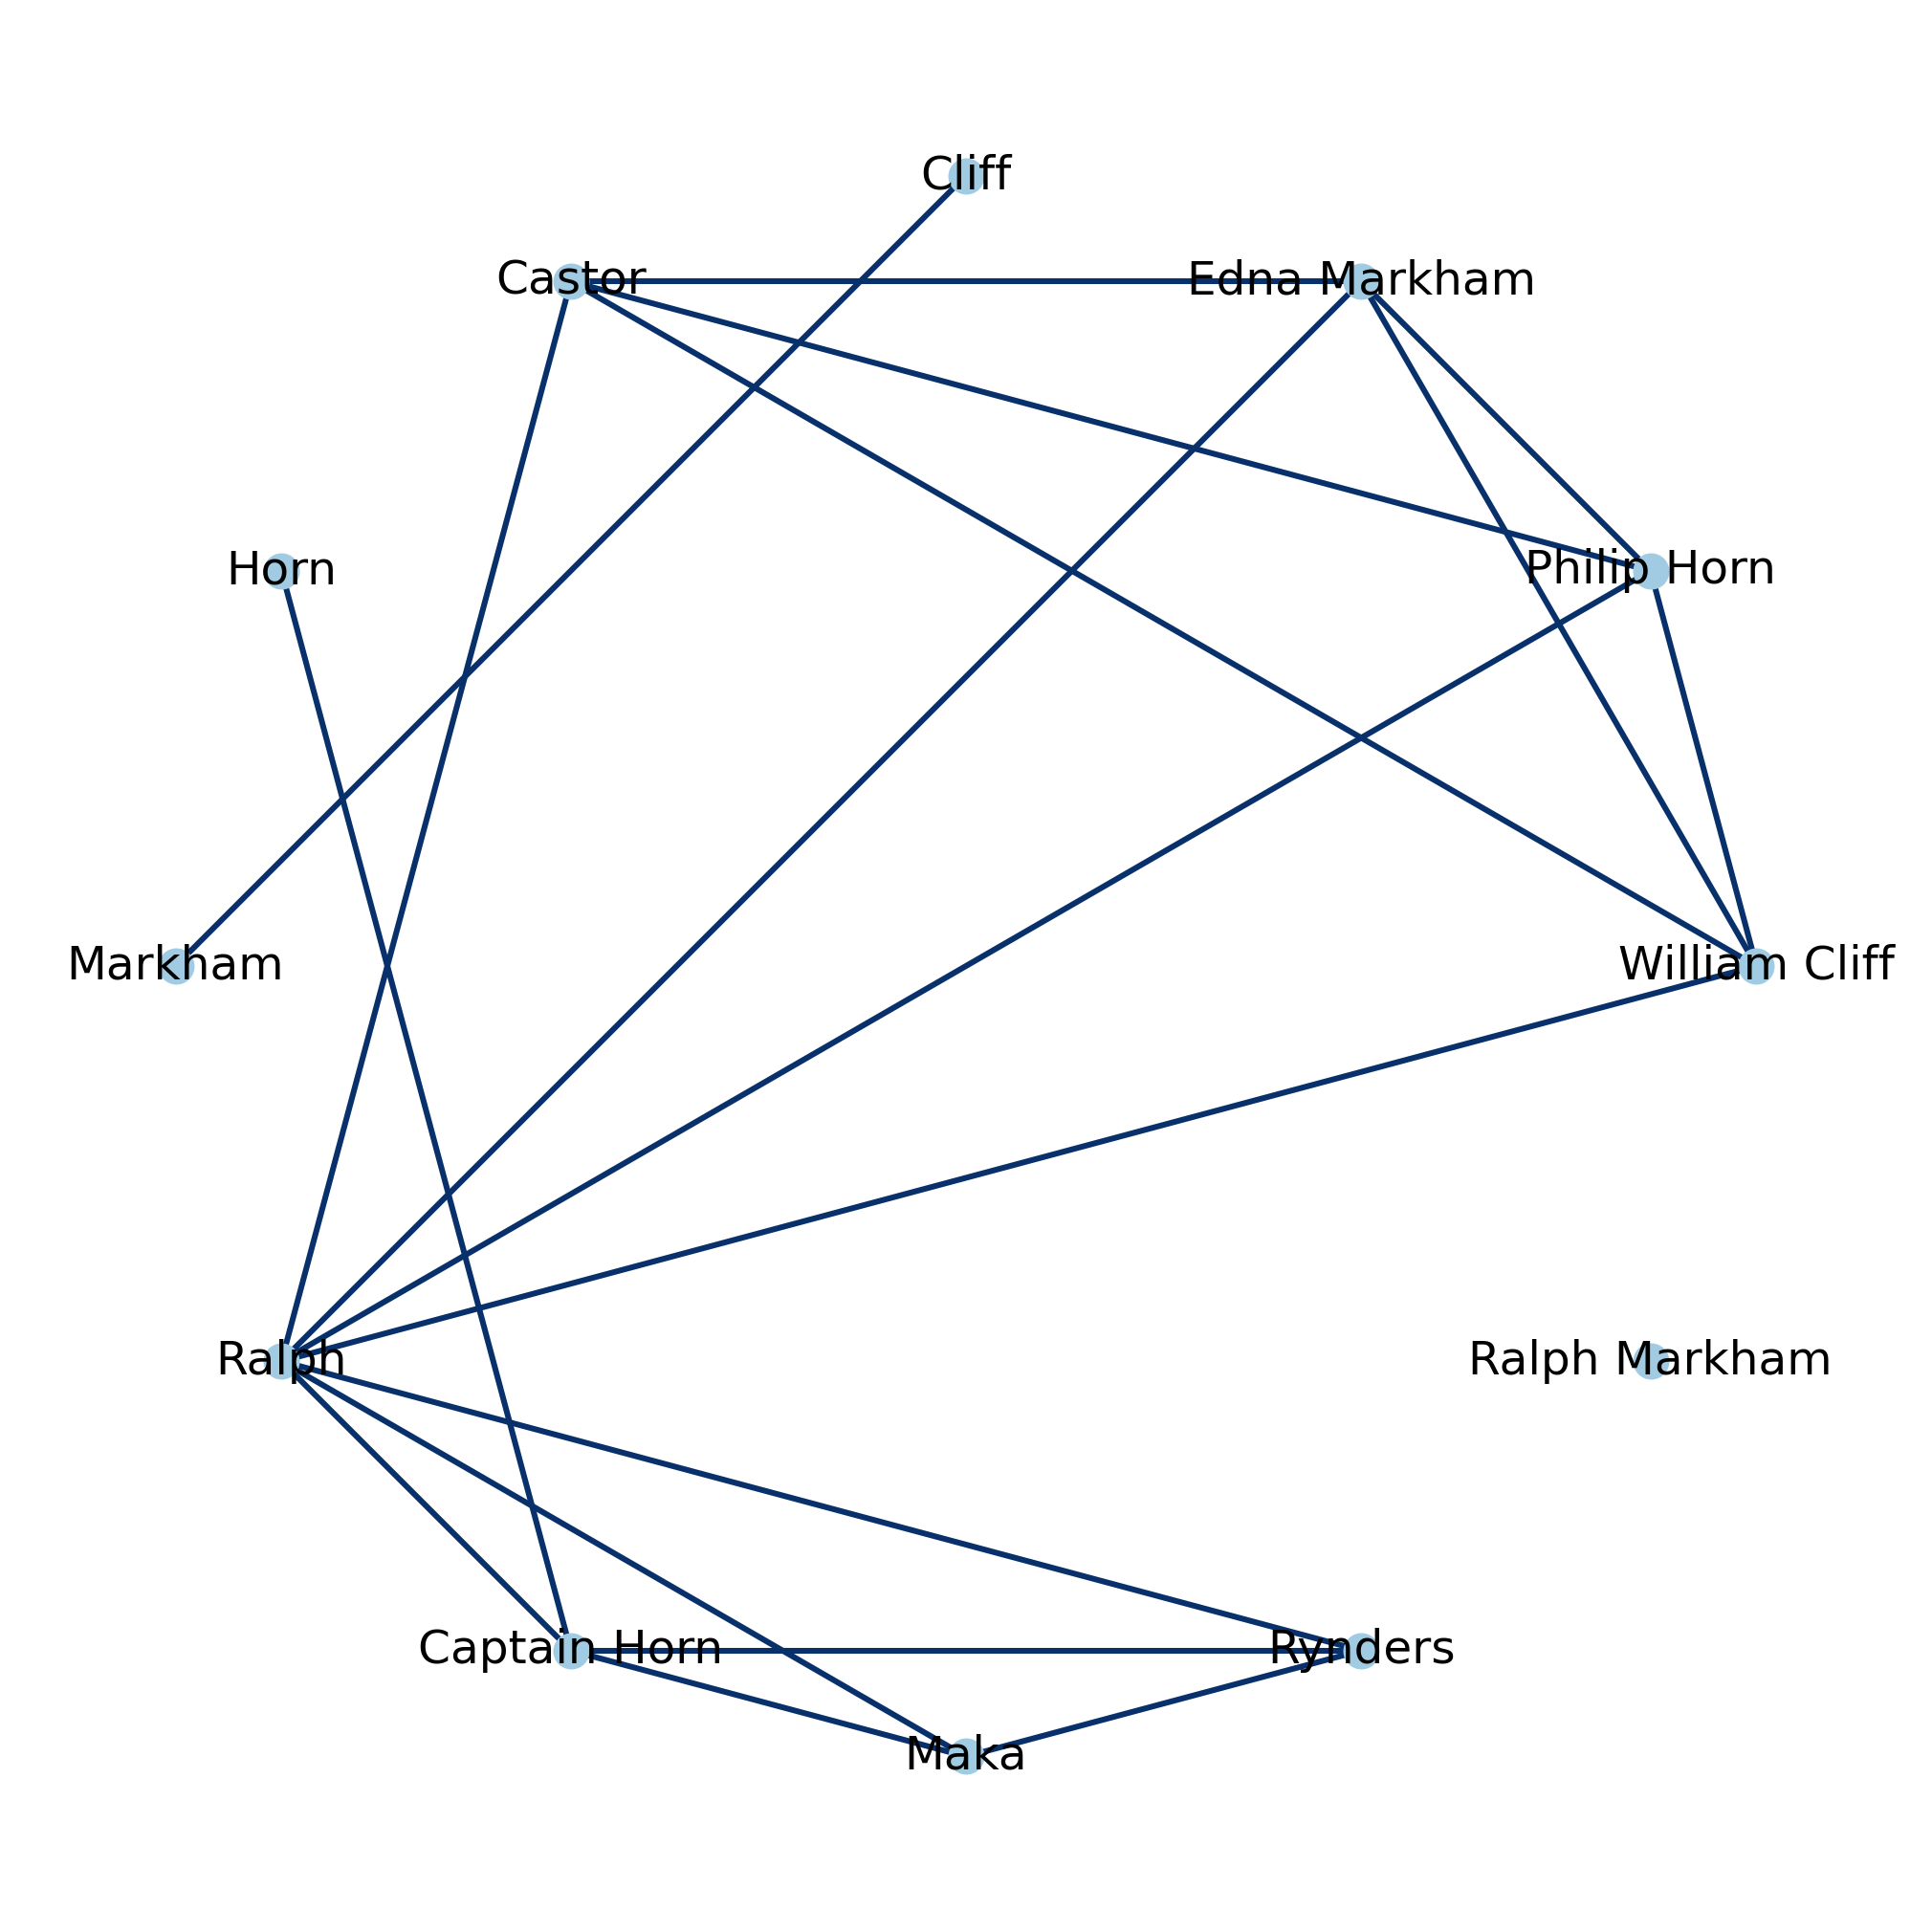

In [38]:
import networkx as nx
import matplotlib.pyplot as plt

matrix = cooccurrence_matrix
name_list = personagens

label = {i: i for i in name_list}
edge_list = edge_list # de celda anterior

# normalized_frequency = np.array(name_frequency) / np.max(name_frequency)

plt.figure(figsize=(20, 20))
G = nx.Graph()
G.add_nodes_from(name_list)
G.add_edges_from(edge_list)
pos = nx.circular_layout(G)
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]
colors = [G[u][v]['color'] for u, v in edges]

nx.draw(G,
        pos, node_color='#A0CBE2',
        #node_size=np.sqrt(normalized_frequency) * 4000,
        edge_cmap=plt.cm.Blues,
        linewidths=10, font_size=35, labels=label, edge_color=colors, with_labels=True, width=weights)

plt.show()

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Sample data
data = [
    # (0, 91, ['Young Hillocks', 'Hillocks', 'Drumsheugh']),
    (1, 168, ['Keep', 'Dominie', 'Keep', 'Keep', 'Geordie Hoo', 'Keep']),
    # (2, 160, ['Tonic Sol-fa']),
    # (4, 188, ['Drumtochty', 'Dominie Jamieson']),
    # Add more data
]

# Create a graph using NetworkX
G = nx.Graph()

# Iterate through data and extract character co-occurrences
for _, _, characters in data:
    for i, character in enumerate(characters):
        for other_character in characters[i + 1:]:
            if G.has_edge(character, other_character):
                G[character][other_character]['weight'] += 1
            else:
                G.add_edge(character, other_character, weight=1)

# Visualization using NetworkX
pos = nx.spring_layout(G, seed=42)
edge_labels = {(u, v): f"{d['weight']}" for u, v, d in G.edges(data=True)}

nx.draw(G, pos, with_labels=True, node_size=100, font_size=10, font_color='black', font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Character Co-occurrence Network")
plt.show()


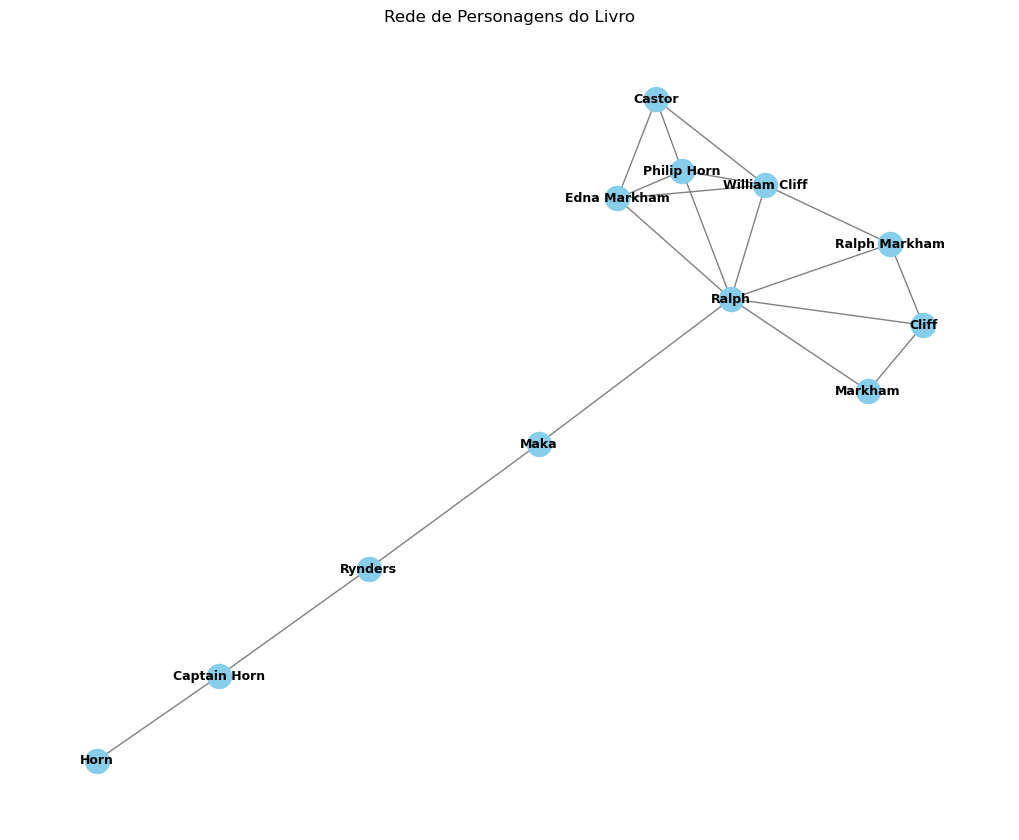

In [39]:
import matplotlib.pyplot as plt
import networkx as nx

# Informações fornecidas
edges = [
    ("Philip Horn", "William Cliff"),
    ("Philip Horn", "Castor"),
    ("Philip Horn", "Edna Markham"),
    ("Philip Horn", "Ralph"),
    ("William Cliff", "Castor"),
    ("William Cliff", "Edna Markham"),
    ("William Cliff", "Ralph"),
    ("William Cliff", "Ralph Markham"),
    ("Castor", "Edna Markham"),
    ("Edna Markham", "Ralph"),
    ("Ralph", "Ralph Markham"),
    ("Ralph", "Cliff"),
    ("Ralph", "Markham"),
    ("Ralph", "Maka"),
    ("Ralph Markham", "Cliff"),
    ("Cliff", "Markham"),
    ("Captain Horn", "Horn"),
    ("Captain Horn", "Rynders"),
    ("Rynders", "Maka")
]

# Criação do grafo
G = nx.Graph()
G.add_edges_from(edges)

# Visualização do grafo
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True,
        node_color="skyblue", node_size=300, font_size=9, font_weight='bold', edge_color='gray', width=1)
plt.title("Rede de Personagens do Livro")
plt.show()
